In [1]:
import numpy as np
import pandas as pd
import librosa
import time
import matplotlib.pyplot as plt
import h5py

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.compat.v1.keras.backend import set_session, clear_session, get_session
import gc

import Networks


Only fully connected layer regularized

In [2]:
# Load saved segments
def Load_Segments(dataset, fold):
    
    if dataset=='ESC10':
        if fold==1:
            hf = h5py.File('ESC10/AMF1.h5', 'r')    
        if fold==2:
            hf = h5py.File('ESC10/AMF2.h5', 'r')
        if fold==3:
            hf = h5py.File('ESC10/AMF3.h5', 'r')
        if fold==4:
            hf = h5py.File('ESC10/AMF4.h5', 'r')
        if fold==5:
            hf = h5py.File('ESC10/AMF5.h5', 'r')

    if dataset=='ESC50':
        if fold==1:
            hf = h5py.File('ESC50/MF1.h5', 'r')    
        if fold==2:
            hf = h5py.File('ESC50/MF2.h5', 'r')
        if fold==3:
            hf = h5py.File('ESC50/MF3.h5', 'r')
        if fold==4:
            hf = h5py.File('ESC50/MF4.h5', 'r')
        if fold==5:
            hf = h5py.File('ESC50/MF5.h5', 'r')
    
    # Get training
    train_d = np.array(hf.get('train_data'))
    train_l = np.array(hf.get('train_label'))


    # Get validation
    val_d = np.array(hf.get('validation_data'))
    val_l = np.array(hf.get('validation_label'))

    # Get test
    test_d = np.array(hf.get('test_label'))
    test_l = np.array(hf.get('test_label'))

    hf.close()
    
    # Cast to float32
    train_d = np.asarray(train_d, dtype=np.float32)
    train_l = np.asarray(train_l, dtype=np.float32)
    
    val_d = np.asarray(val_d, dtype=np.float32)
    val_l = np.asarray(val_l, dtype=np.float32)
    
    test_d = np.asarray(test_d, dtype=np.float32)
    test_l = np.asarray(test_l, dtype=np.float32)
    
    return train_d, train_l, val_d, val_l, test_d, test_l


def CreateTrainingSet10(data, label, batch_size=32):
    
    # Shuffle the folds
    rnd_indices = np.arange(0, len(data))
    rnd_indices = np.random.shuffle(rnd_indices)
    
    data = data[rnd_indices].reshape((len(data), 60, 41, 3))
    label = label[rnd_indices].reshape((len(label), 10))
    
    
    data = data.astype(np.float32)
    label = label.astype(np.float32)
    
    '''
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0,
                                                              height_shift_range=0,
                                                              horizontal_flip=False,
                                                              vertical_flip=False) 
    
    # Shuffle all elements at every iteration
    training_dataset = datagen.flow(data, label, batch_size=batch_size, shuffle=True)
    '''
    
    training_dataset = tf.data.Dataset.from_tensor_slices((data, label))
    
    # Shuffle all elements at every iteration
    training_dataset = training_dataset.shuffle(len(training_dataset))
    
    # Define batch_size and prefetch size
    training_dataset = training_dataset.batch(batch_size=batch_size).prefetch(buffer_size=1)
    
    return training_dataset


def CreateTrainingSet50(data, label, batch_size=32):
    
    # Shuffle the folds
    rnd_indices = np.arange(0, len(data))
    rnd_indices = np.random.shuffle(rnd_indices)
    
    data = data[rnd_indices].reshape((len(data), 60, 41, 3))
    label = label[rnd_indices].reshape((len(label), 50))
    
    
    data = data.astype(np.float32)
    label = label.astype(np.float32)
    
    '''
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0,
                                                              height_shift_range=0,
                                                              horizontal_flip=False,
                                                              vertical_flip=False) 
    
    # Shuffle all elements at every iteration
    training_dataset = datagen.flow(data, label, batch_size=batch_size, shuffle=True)
    '''
    
    training_dataset = tf.data.Dataset.from_tensor_slices((data, label))
    
    # Shuffle all elements at every iteration
    training_dataset = training_dataset.shuffle(len(training_dataset))
    
    # Define batch_size and prefetch size
    training_dataset = training_dataset.batch(batch_size=batch_size).prefetch(buffer_size=1)
    
    return training_dataset


def CreateValidationSet(data, label, batch_size=32):
    
    data = data.astype(dtype=np.float32)
    label = label.astype(dtype=np.float32)
    
    # Create and cache training
    validation_dataset = tf.data.Dataset.from_tensor_slices((data, label))
    
    # Cache dataset
    #validation_dataset = validation_dataset.cache(name)
    
    # Define batch_size and prefetch size
    validation_dataset = validation_dataset.batch(batch_size=batch_size).prefetch(buffer_size=1)
    
    return validation_dataset


def train(net, max_epochs, training_dataset, validation_dataset, verbose=True):
    
    epoch_loss= []
    epoch_acc = []

    epoch_vl = []
    epoch_va = []

    # Loop over the epochs
    for epoch in range(max_epochs):


        step_loss = []
        step_acc = []

        step_vl = []
        step_va = []

        batches = 0
        start = time.time()
        # train over mini-batches
        for x_batch, y_batch in training_dataset:

            # train on batch
            step_stats = net.train_on_batch(x_batch, y_batch)

            # save loss and accuracy
            step_loss.append(step_stats[0])
            step_acc.append(step_stats[1])


        # compute validation stats
        for x_batch, y_batch in validation_dataset:

            # compute validation stats
            val_stats = net.test_on_batch(x_batch, y_batch)

            # save loss and accuracy
            step_vl.append(val_stats[0])
            step_va.append(val_stats[1])


        end = time.time()

        # Save the mean loss and accuracy of the entire epoch
        epoch_loss.append(np.mean(step_loss))
        epoch_acc.append(np.mean(step_acc))
        epoch_vl.append(np.mean(step_vl))
        epoch_va.append(np.mean(step_va))

        # Print epoch training stats
        if verbose:
            print("Epoch %2d: \t t-loss: %3.6f \t t-acc: %.6f \t v-loss: %3.6f \t v-acc: %.6f \t time: %3.3f" % (epoch + 1, epoch_loss[-1], epoch_acc[-1], epoch_vl[-1], epoch_va[-1], (end - start)))
        
    return epoch_loss, epoch_acc, epoch_vl, epoch_va
    
    
# Reset Keras Session
def reset_keras():
    
    # Get and close session
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()
    
    # Garbage collector call
    gc.collect()
    
    # Init new session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))

## Cross-Fold Test

In [3]:
fold_train_loss = []
fold_train_accuracy = []
fold_valid_loss = []
fold_valid_accuracy = []
fold_test = []

In [4]:
# Define training parameters
max_epochs = 100
lr = 0.002
batch_size = 256

# Loop over the functions
for i in range(1, 6):
    
    print(f'\n#############################################################')
    print(f'######################## FOLD-{i} #############################')
    print(f'#############################################################')
    # load the fold data
    train_d, train_l, val_d, val_l, test_d, test_l = Load_Segments('ESC10', i)
    
    # Generate training and validation dataset
    training_dataset = CreateTrainingSet10(train_d, train_l, batch_size=batch_size)
    validation_dataset = CreateValidationSet(val_d, val_l, batch_size=batch_size)
    
    # Initialize the network
    net = Networks.MFNetReg10([60, 41, 3])
    loss_f = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    opt = tf.keras.optimizers.SGD(lr=lr, momentum=0.9, nesterov=True)
    net.compile(optimizer=opt, loss=loss_f, metrics=["accuracy"])
    
    # Train the network
    epoch_loss, epoch_acc, epoch_vl, epoch_va = train(net, max_epochs, training_dataset, validation_dataset, verbose=True)
    
    # Append lossed for confidence plot
    fold_train_loss.append(epoch_loss)
    fold_train_accuracy.append(epoch_acc)
    fold_valid_loss.append(epoch_vl)
    fold_valid_accuracy.append(epoch_va)
    
    reset_keras()


#############################################################
######################## FOLD-1 #############################
#############################################################
Epoch  1: 	 t-loss: 1.852450 	 t-acc: 0.388706 	 v-loss: 2.289411 	 v-acc: 0.131288 	 time: 10.449
Epoch  2: 	 t-loss: 1.148160 	 t-acc: 0.589666 	 v-loss: 2.281143 	 v-acc: 0.114081 	 time: 5.789
Epoch  3: 	 t-loss: 0.892143 	 t-acc: 0.688574 	 v-loss: 2.277970 	 v-acc: 0.112500 	 time: 5.791
Epoch  4: 	 t-loss: 0.725079 	 t-acc: 0.749967 	 v-loss: 2.289360 	 v-acc: 0.112500 	 time: 5.786
Epoch  5: 	 t-loss: 0.628610 	 t-acc: 0.786249 	 v-loss: 2.295902 	 v-acc: 0.112500 	 time: 5.792
Epoch  6: 	 t-loss: 0.556536 	 t-acc: 0.814655 	 v-loss: 2.336333 	 v-acc: 0.112500 	 time: 5.819
Epoch  7: 	 t-loss: 0.484717 	 t-acc: 0.834555 	 v-loss: 2.284917 	 v-acc: 0.121300 	 time: 5.756
Epoch  8: 	 t-loss: 0.425827 	 t-acc: 0.858992 	 v-loss: 2.307030 	 v-acc: 0.122100 	 time: 5.786
Epoch  9: 	 t-loss: 0.369367

In [5]:
# Convert lists to array
fold_train_loss = np.asarray(fold_train_loss)
fold_train_accuracy = np.asarray(fold_train_accuracy)
fold_valid_loss = np.asarray(fold_valid_loss)
fold_valid_accuracy = np.asarray(fold_valid_accuracy)

# Compute mean and confidence interval
m_tl = []
m_ta = []
m_vl = []
m_va = []

ci_tl = []
ci_ta = []
ci_vl = []
ci_va = []

for i in range(max_epochs):
    m_tl.append(np.mean(fold_train_loss[:, i]))
    m_ta.append(np.mean(fold_train_accuracy[:, i]))
    m_vl.append(np.mean(fold_valid_loss[:, i]))
    m_va.append(np.mean(fold_valid_accuracy[:, i]))
    
    ci_tl.append(1.96*np.std(fold_train_loss[:, i])/np.mean(fold_train_loss[:, i]))
    ci_ta.append(1.96*np.std(fold_train_accuracy[:, i])/np.mean(fold_train_accuracy[:, i]))
    ci_vl.append(1.96*np.std(fold_valid_loss[:, i])/np.mean(fold_valid_loss[:, i]))
    ci_va.append(1.96*np.std(fold_valid_accuracy[:, i])/np.mean(fold_valid_accuracy[:, i]))

m_tl = np.asarray(m_tl)
m_ta = np.asarray(m_ta)
m_vl = np.asarray(m_vl)
m_va = np.asarray(m_va)

ci_tl = np.asarray(ci_tl)
ci_ta = np.asarray(ci_ta)
ci_vl = np.asarray(ci_vl)
ci_va = np.asarray(ci_va)

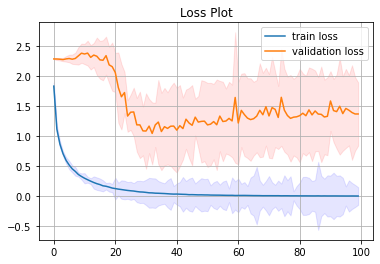

In [6]:
# Plot loss
fig, ax = plt.subplots()
ax.plot(m_tl, label='train loss')
ax.fill_between(np.arange(0, max_epochs), (m_tl-ci_tl), (m_tl+ci_tl), color='b', alpha=.1)
ax.plot(m_vl, label='validation loss')
ax.fill_between(np.arange(0, max_epochs), (m_vl-ci_vl), (m_vl+ci_vl), color='r', alpha=.1)
plt.grid()
plt.legend()
plt.title('Loss Plot')
plt.show()

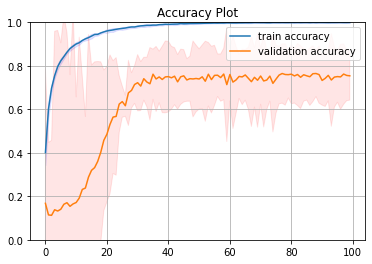

In [7]:
# Plot accuracy
fig, ax = plt.subplots()
ax.plot(m_ta, label='train accuracy')
ax.fill_between(np.arange(0, max_epochs), (m_ta-ci_ta), (m_ta+ci_ta), color='b', alpha=.1)
ax.plot(m_va, label='validation accuracy')
ax.fill_between(np.arange(0, max_epochs), (m_va-ci_va), (m_va+ci_va), color='r', alpha=.1)
plt.grid()
plt.legend()
plt.ylim(0, 1)
plt.title('Accuracy Plot')
plt.show()